<a href="https://www.kaggle.com/code/luchozm22/signlanguagecnn-ft-val?scriptVersionId=272729627" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import keras_cv
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.applications import MobileNetV3Large
from keras import  Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.metrics import Precision, Recall, F1Score, TopKCategoricalAccuracy
from keras.layers import RandomRotation, RandomZoom
from keras_cv.layers import RandomCutout
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input


2025-11-01 23:27:59.645005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762039679.917028      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762039679.983064      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# GLOBAL VARIABLES
IMG_SIZE = (200, 200)
BATCH_SIZE = 96
VALIDATION_LOCATION = '/kaggle/input/asl-dataset-corrected/asl-test_corrected'
FINETUNNING_LOCATION = '/kaggle/input/asl-finetuning/Finetune_alphabet'
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42
EPOCHS = 15
N_CLASSES = 29

In [3]:
def get_metrics():
    return  [ Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1_score', average='macro'),
            TopKCategoricalAccuracy(name='top_k_cat_acc'),
        ]

In [4]:
def get_lr_callback(batch_size=BATCH_SIZE, mode='cos', epochs=EPOCHS, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

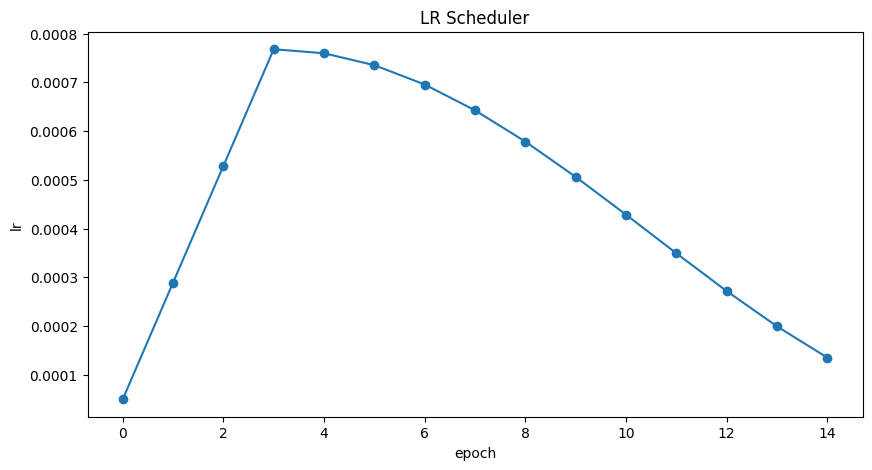

In [5]:
lr_cb = get_lr_callback(BATCH_SIZE, plot=True)

In [6]:
def get_callbacks(model_name, metric):
   
    val_metric = 'val_' + metric

    lr_cb = get_lr_callback(BATCH_SIZE)
    
    # Model Checkpoint
    ckpt_cb = keras.callbacks.ModelCheckpoint((model_name + '_best.weights.h5'),
                                             monitor= val_metric,
                                             save_best_only=True,
                                             save_weights_only=True,
                                             mode='max')
    # Early Stopping
    es_cb = keras.callbacks.EarlyStopping(
        monitor=val_metric,  
        mode='max',          
        patience=8,        
        restore_best_weights=True 
    )

    return [lr_cb, ckpt_cb, es_cb]

In [7]:
def create_transfer_model(n_classes, input_shape=(200, 200, 3)):
    
    inputs = Input(shape=input_shape, name="input_layer")
    
    base_model = MobileNetV3Large(
        input_tensor=inputs,
        weights='imagenet',  
        include_top=False,   
        pooling=None        
    )   
    base_model.trainable = False
    x = base_model.output

    x = GlobalAveragePooling2D(name="global_avg_pool")(x)
    
    # Now add the classifier head you defined
    x = Dense(256, activation="relu", name="dense_head_1")(x)
    x = Dropout(0.5, name="dropout_head")(x)
    
    # The output layer for n_classes
    outputs = Dense(n_classes, activation="softmax", name="output_layer", dtype="float32")(x)
    
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [8]:
def compile_model(model, optimizer, loss, metrics):
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )

# Data Set

In [9]:
def preprocess_ft(img, label):

    img = tf.cast(img, tf.float32) 
    img = tf.image.resize(img, IMG_SIZE)
    img_preprocessed = preprocess_input(img)
    if label == 26:
        label = 27
    label = tf.one_hot(label, depth=N_CLASSES)

    return img_preprocessed, label

def preprocess(img, label):

    img = tf.cast(img, tf.float32) 
    img = tf.image.resize(img, IMG_SIZE)
    img_preprocessed = preprocess_input(img)
    label = tf.one_hot(label, depth=N_CLASSES)

    return img_preprocessed, label

In [10]:
random_rotation = RandomRotation(factor=(-0.18, 0.18), dtype=tf.float32)
random_cutout = RandomCutout(height_factor=0.05, width_factor=0.05, dtype=tf.float32)
random_zoom = RandomZoom(height_factor=0.1, width_factor=0.1, dtype=tf.float32)

I0000 00:00:1762039701.989814      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [11]:
def augment_pre_batch(img, label):
    # Apply augmentations randomly
    if tf.random.uniform([]) < 0.5:
        img = random_rotation(img)

    if tf.random.uniform([]) < 0.5:
        img = random_cutout(img)

    if tf.random.uniform([]) < 0.5:
        img = random_zoom(img)

    return img, label


In [12]:
def build_data_set(folder_loc, split=None, image_size=IMG_SIZE, batch_size=BATCH_SIZE, isTrain=False, data_augmentation=False, finetuning=False):
    loader_args = {
        'directory': folder_loc,
        'image_size': image_size,
        'seed': SEED,
        'label_mode': 'int',
        'batch_size': None
    }

    if split:
        loader_args['validation_split'] = split
        loader_args['subset'] = "training" if isTrain else "validation"
    
    ds = keras.preprocessing.image_dataset_from_directory(**loader_args)

    if finetuning:
        ds = ds.map(preprocess_ft, num_parallel_calls=AUTOTUNE)
    else: 
        ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)
    if isTrain:
        #ds = ds.cache()
        ds = ds.shuffle(buffer_size=256)
    
    if isTrain and data_augmentation:
       ds = ds.map(augment_pre_batch, num_parallel_calls=AUTOTUNE)


    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(AUTOTUNE)
    

    return ds

In [13]:
train_ds = build_data_set(FINETUNNING_LOCATION, split=0.2, isTrain=True, data_augmentation=True, finetuning=True)
test_ds = build_data_set(FINETUNNING_LOCATION, split=0.2, isTrain=False, finetuning=True) 

Found 2700 files belonging to 27 classes.
Using 2160 files for training.
Found 2700 files belonging to 27 classes.
Using 540 files for validation.


# Load Model

In [14]:
cnn_tl_model = create_transfer_model(N_CLASSES) 
weights = '/kaggle/input/signlanguagecnn/MobileNetV3_best.weights.h5'
cnn_tl_model.load_weights(weights)

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
loss_tl = keras.losses.CategoricalCrossentropy(label_smoothing=0.02)
opt_finetune = keras.optimizers.Adam(learning_rate=1e-5)
all_callbacks = get_callbacks('MobileNetV3_finetune', 'f1_score') 

compile_model(cnn_tl_model, opt_finetune, loss_tl, get_metrics())

# Validation

In [16]:
valid_ds = build_data_set(VALIDATION_LOCATION, isTrain=False) 

Found 870 files belonging to 29 classes.


In [17]:
og_validation = cnn_tl_model.evaluate(valid_ds, verbose=1, return_dict=True)
print(og_validation)

I0000 00:00:1762039714.004229      57 service.cc:148] XLA service 0x79dc10002c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762039714.005529      57 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762039714.799654      57 cuda_dnn.cc:529] Loaded cuDNN version 90300


3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - f1_score: 0.2291 - loss: 4.2183 - precision: 0.3183 - recall: 0.1921 - top_k_cat_acc: 0.5376 

I0000 00:00:1762039720.198114      57 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - f1_score: 0.2271 - loss: 4.3502 - precision: 0.2929 - recall: 0.1770 - top_k_cat_acc: 0.5451
{'f1_score': 0.23773092031478882, 'loss': 4.350454807281494, 'precision': 0.28764477372169495, 'recall': 0.17245370149612427, 'top_k_cat_acc': 0.5520833134651184}


# FINE TUNIG

In [18]:
# Freeze and Unfreze layers
FINE_TUNE_LAYERS = 14

inner_layers = cnn_tl_model.layers

for layer in inner_layers[:-FINE_TUNE_LAYERS]:
    layer.trainable = False

for layer in inner_layers[-FINE_TUNE_LAYERS:]:
    layer.trainable = True
    print(f"Unfrozen Layer: {layer.name}")

Unfrozen Layer: expanded_conv_14_squeeze_excite_relu
Unfrozen Layer: expanded_conv_14_squeeze_excite_conv_1
Unfrozen Layer: re_lu_18
Unfrozen Layer: expanded_conv_14_squeeze_excite_mul
Unfrozen Layer: expanded_conv_14_project
Unfrozen Layer: expanded_conv_14_project_bn
Unfrozen Layer: expanded_conv_14_add
Unfrozen Layer: conv_1
Unfrozen Layer: conv_1_bn
Unfrozen Layer: activation_19
Unfrozen Layer: global_avg_pool
Unfrozen Layer: dense_head_1
Unfrozen Layer: dropout_head
Unfrozen Layer: output_layer


In [19]:
history_finetune = cnn_tl_model.fit(
    train_ds, 
    validation_data=test_ds, 
    epochs=EPOCHS, 
    callbacks=all_callbacks, 
    verbose=1
)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 29s 529ms/step - f1_score: 0.1095 - loss: 5.3738 - precision: 0.1394 - recall: 0.0618 - top_k_cat_acc: 0.3608 - val_f1_score: 0.1740 - val_loss: 4.7028 - val_precision: 0.2390 - val_recall: 0.1250 - val_top_k_cat_acc: 0.4437 - learning_rate: 5.0000e-05
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 501ms/step - f1_score: 0.1090 - loss: 4.2737 - precision: 0.1479 - recall: 0.0346 - top_k_cat_acc: 0.3769 - val_f1_score: 0.1924 - val_loss: 3.3789 - val_precision: 0.3592 - val_recall: 0.1063 - val_top_k_cat_acc: 0.5125 - learning_rate: 2.8933e-04
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 501ms/step - f1_score: 0.1495 - loss: 2.9988 - precision: 0.5242 - recall: 0.0313 - top_k_cat_acc: 0.4937 - val_f1_score: 0.2768 - val_loss: 2.9107 - val_precision: 0.5027 - val_recall: 0.1937 - val_top_k_cat_acc: 0.6438 - learning_rate: 5.2867e-04
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 496ms/step - f1_score: 0.2332 - loss: 2.5623 - precision: 0.6887 - recall: 0.0887 - t

In [20]:
def graph_history_metrics(history, metrics, display_metric):

    val_dp_metric = 'val_' + display_metric
    
    best_epoch = np.argmax(history.history[val_dp_metric])
    best_score = history.history[val_dp_metric][best_epoch]
    print('>>> Best Epoch: ', best_epoch+1)
    
    epochs_range = range(1, len(history.history[display_metric]) + 1)
    plt.figure(figsize=(12, 15))
        
    cols = 2
    rows = math.ceil(len(metrics) / cols)
    
    for i, metric_name in enumerate(metrics):
        
        if metric_name not in history.history:
            print(f"Warning: Metric '{metric_name}' not found in history. Skipping plot.")
            continue
        
        val_metric_name = 'val_' + metric_name
        if val_metric_name not in history.history:
            print(f"Warning: Validation metric '{val_metric_name}' not found in history. Skipping plot.")
            continue
    
        metric = history.history[metric_name]
        val_metric = history.history[val_metric_name]
        
    
        plt.subplot(rows, cols, i + 1)
        
        plt.plot(epochs_range, metric, label='Training')
        plt.plot(epochs_range, val_metric, label='Validation')
        
        plt.title(metric_name.replace('_', ' ').capitalize())
        plt.xlabel('Epoch')
        plt.ylabel(metric_name.capitalize())
        plt.legend()
        plt.grid()
    
    
    plt.tight_layout()
    plt.show()

>>> Best Epoch:  13


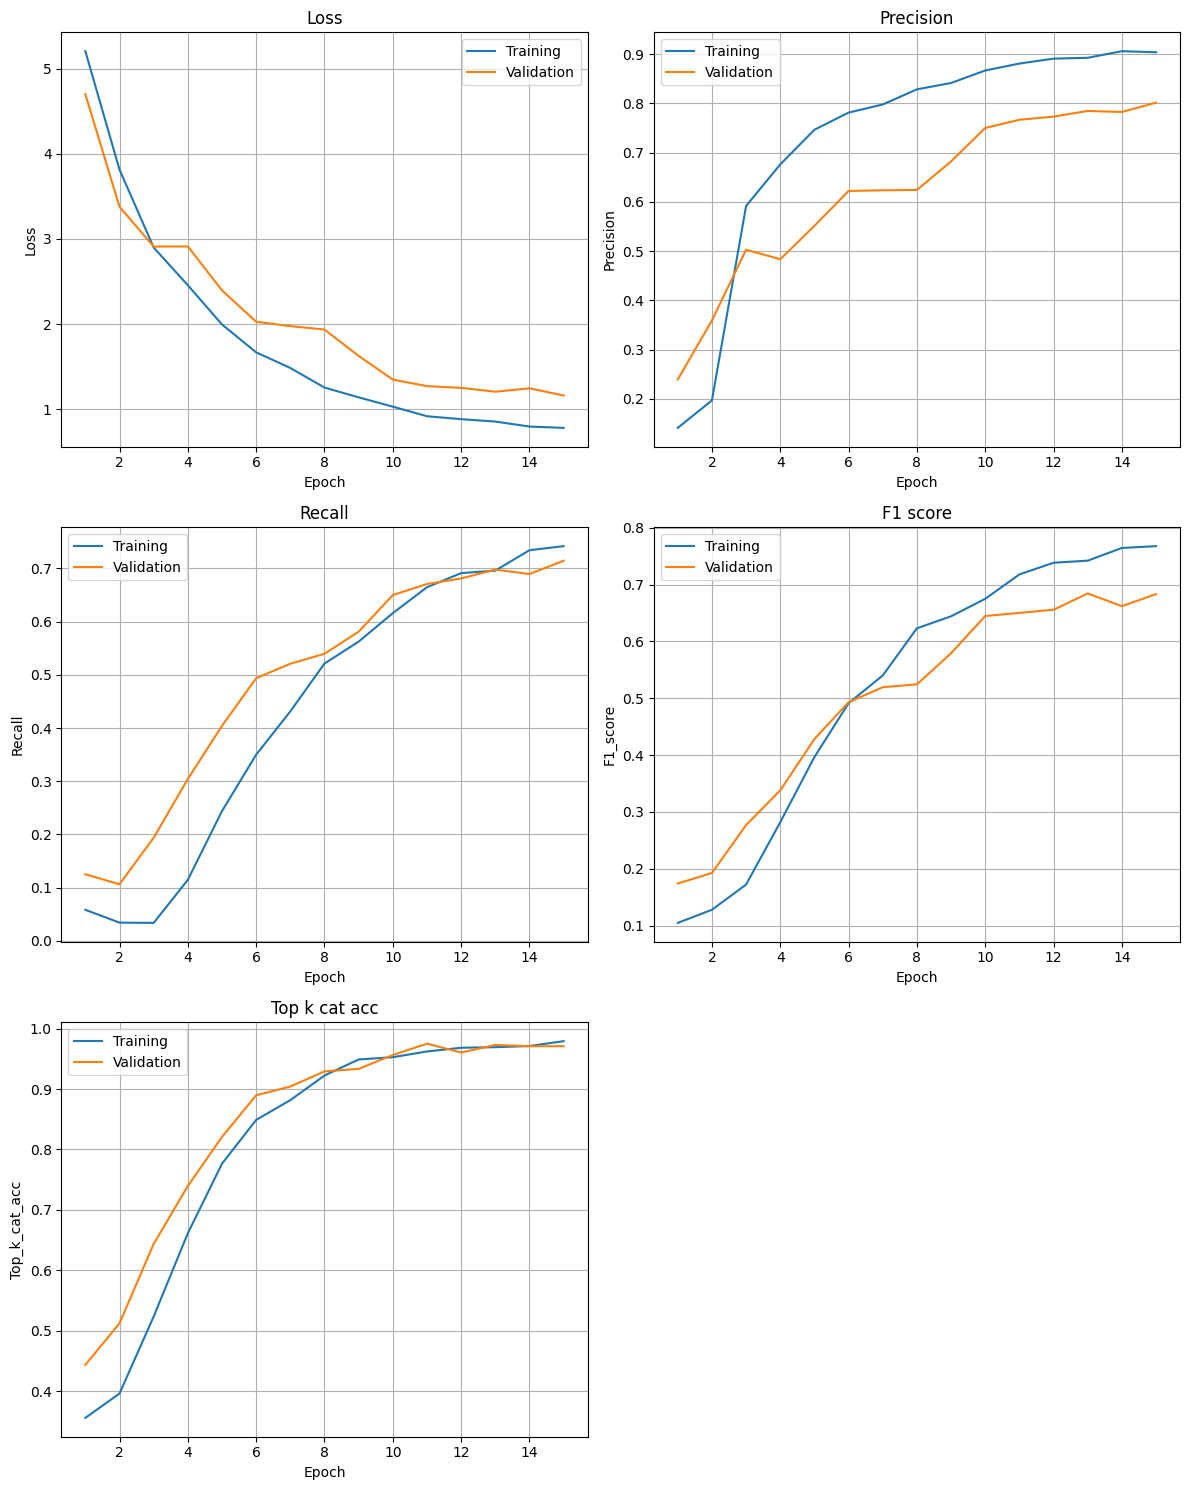

In [21]:
metrics = ['loss', 'precision', 'recall', 'f1_score', 'top_k_cat_acc']
graph_history_metrics(history_finetune, metrics, metrics[3])

In [22]:
cnn_tl_model.save('mobilenet_sign_language_model.keras')

In [23]:
ft_validation = cnn_tl_model.evaluate(valid_ds, verbose=1, return_dict=True)
print(ft_validation)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - f1_score: 0.3301 - loss: 2.9279 - precision: 0.4128 - recall: 0.2856 - top_k_cat_acc: 0.7666
{'f1_score': 0.34520408511161804, 'loss': 2.983464002609253, 'precision': 0.41038525104522705, 'recall': 0.28356480598449707, 'top_k_cat_acc': 0.7627314925193787}
